## Inference over a BN using Belief Propagation

Consider the following joint probability distribution:
\begin{align}
p(x_1,x2,x3)=p(x_1)p(x_2|x_1)p(x_3|x_2)p(x_4|x_2)
\end{align}

where $x_1\in\{0,1\}$, $x_2\in\{0,1\}$,$x_3\in\{0,1,2\}$ and $x_4\in\{0,1,2,3\}$

The values of the CPD factors are know. Here we simply worry about inference. The goal is to learn how to use and interpret the provided library.

In [11]:
import numpy as np
from lib import Message_passing_BN as mp
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

#p(x1)
CPD_1=np.array([0.5, 0.5])

#p(x2|x1)
CPD_2=np.array([0.75, 0.25, 0.3, 0.7])

#p(x3|x2)
CPD_3=np.array([0.15, 0.8,0.05,0.1,0.3,0.6])

#p(x4|x2)
CPD_4=np.array([0.05,0.8,0.05,0.1,0.2,0.2,0.5,0.1])

A CPD of the form $p(x_c|x_a,x_b)$ is a table of $c_c \times c_a \times c_b$ entries, where $c_j$ is the cardinality of the R.V. $x_j$. We store the complete CPD in a vector of $c_c \times c_a \times c_b$ and we use a tree encoding to associate each position of the vector with a configuration of $(x_c,x_a,x_b)$.

For instance, assume they are binary variables. For the tree encoding, we assume a given encoding order. In our case $x_a\rightarrow x_b\rightarrow x_c\rightarrow x_i$. The following plot illustrates the encoding. 


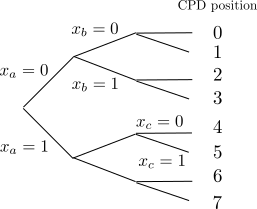

In [12]:
Image(filename='files/tree.png')

** We provide two functions for easy encoding/decoding in CPD tables**

Let use the function mp.CPD_position_to_variable_index to find the encoding for each position of CPD_3, which stores the values $p(x_3|x_2)$. The sintax of the function is

``var_indexes=mp.CPD_position_to_variable_index(position,v_card,CPD_length)``

where v_card is the vector of cardinalities **in the encoding order**. In this case $x_2 \rightarrow x_3$ and thus `v_card=[2,3]`.

Similarly the function variable_index_to_CPD_position returns the CPD position for a given configuration of the variables. The sintax of the function is

``CPD_position=variable_index_to_CPD_position(var_index,v_card,CPD_size)``

where var_index is the variable array of indexes. 

In [13]:
values_x1=[0,1]           #Note that the actual values of the variables are irrelevant!
values_x2=[0,1]           #All the information is in the CPDs! We just care about indexes 
values_x3=[0,1,2]
values_x4=[0,1,2,3]

for position,cpd_val in enumerate(CPD_3):

    var_index=mp.CPD_position_to_variable_index(position,[2,3],6)
    
    print("Position %d of CPD_3 correspond to p(x_3=%s|x_2=%d)\n" 
          %(position,values_x3[var_index[1]],values_x2[var_index[0]]))

print("The CPD position corresponding to p(x3=%d|x2=%d) is %d\n"
     %(values_x3[2],values_x2[1],mp.variable_index_to_CPD_position([1,2],[2,3],6)))    

Position 0 of CPD_3 correspond to p(x_3=0|x_2=0)

Position 1 of CPD_3 correspond to p(x_3=1|x_2=0)

Position 2 of CPD_3 correspond to p(x_3=2|x_2=0)

Position 3 of CPD_3 correspond to p(x_3=0|x_2=1)

Position 4 of CPD_3 correspond to p(x_3=1|x_2=1)

Position 5 of CPD_3 correspond to p(x_3=2|x_2=1)

The CPD position corresponding to p(x3=2|x2=1) is 5



### Defining the factor graph associated to the BN

Before running inference using BP, we will define the variable nodes and the graph. The factor graph associated to the BN is shown below

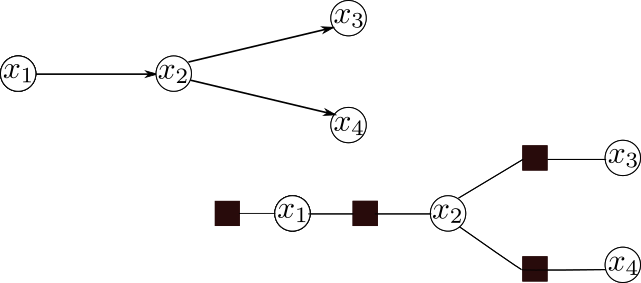

In [14]:
Image(filename='files/BN1.png')

In [15]:
v_card=[2,2,3,4]         #Vector of cardinalities

node_x1=mp.create_var_node(ID=1,cardinality=v_card[0],neighbor_order=[1,2],observed_value_index=-1)
node_x2=mp.create_var_node(ID=2,cardinality=v_card[1],neighbor_order=[2,3,4],observed_value_index=-1)
node_x3=mp.create_var_node(ID=3,cardinality=v_card[2],neighbor_order=[3],observed_value_index=-1)
node_x4=mp.create_var_node(ID=4,cardinality=v_card[3],neighbor_order=[4],observed_value_index=-1)

list_var_nodes=[node_x1,node_x2,node_x3,node_x4]

factor_1=mp.create_factor_node(ID=1,neighbors=[node_x1],CPD=CPD_1)
factor_2=mp.create_factor_node(ID=2,neighbors=[node_x1,node_x2],CPD=CPD_2)
factor_3=mp.create_factor_node(ID=3,neighbors=[node_x2,node_x3],CPD=CPD_3)
factor_4=mp.create_factor_node(ID=4,neighbors=[node_x2,node_x4],CPD=CPD_4)

list_factor_nodes=[factor_1,factor_2,factor_3,factor_4]

### Running BP message passing

This is straightforward given the functions provided. As the graph is a tree, we know the algorithm will converge in a few iterations

In [16]:
L=5 #BP iterations

for l in range(L):
    
    #Factor update
    for factor_node in list_factor_nodes:
        mp.update_factor_to_var(factor_node)
        
    #Variable update
    for var_node in list_var_nodes:
        mp.update_var_to_factor(var_node)

list_marg=[]

for var_node in list_var_nodes:
    marg=mp.compute_var_marginal(var_node)
    list_marg.append(marg)
    print("The marginal pmf of node x_%d is=" %(var_node['ID']))
    print(marg)


The marginal pmf of node x_1 is=
[[ 0.5]
 [ 0.5]]
The marginal pmf of node x_2 is=
[[ 0.525]
 [ 0.475]]
The marginal pmf of node x_3 is=
[[ 0.12625]
 [ 0.5625 ]
 [ 0.31125]]
The marginal pmf of node x_4 is=
[[ 0.12125]
 [ 0.515  ]
 [ 0.26375]
 [ 0.1    ]]


### Inference with partial observations

Imagine we observe x_3 and we are interested in computing the marginal distribution of the rest of variables. This is straightforward to implement.

In [17]:
# The function mp.initialize_variable set the value to their current observed state

mp.initialize_variable(var_node=node_x3,observed_value_index=0)

# Equivalently we can define again the variable_node

#node_x3=mp.create_var_node(ID=3,cardinality=v_card[2],neighbor_order=[3],observed_value_index=1)

#IMPORTANT, we have to re-initialize all factor nodes!! Intermediate messages were not erased from the previous BP

mp.initialize_factor_msgs(factor_1,neighbors=[node_x1])
mp.initialize_factor_msgs(factor_2,neighbors=[node_x1,node_x2])
mp.initialize_factor_msgs(factor_3,neighbors=[node_x2,node_x3])
mp.initialize_factor_msgs(factor_4,neighbors=[node_x2,node_x4])

And now we can run BP again ...

In [18]:
L=5 #BP iterations

for l in range(L):
    
    #Factor update
    for factor_node in list_factor_nodes:
        mp.update_factor_to_var(factor_node)
        
    #Variable update
    for var_node in list_var_nodes:
        mp.update_var_to_factor(var_node)

list_marg=[]

for var_node in list_var_nodes:
    marg=mp.compute_var_marginal(var_node)
    list_marg.append(marg)
    print("The marginal pmf of node x_%d is=" %(var_node['ID']))
    print(marg)

The marginal pmf of node x_1 is=
[[ 0.54455446]
 [ 0.45544554]]
The marginal pmf of node x_2 is=
[[ 0.62376238]
 [ 0.37623762]]
The marginal pmf of node x_3 is=
[[  1.00000000e+00]
 [  6.16587561e-87]
 [  3.41178451e-87]]
The marginal pmf of node x_4 is=
[[ 0.125]
 [ 0.5  ]
 [ 0.275]
 [ 0.1  ]]


### Inference of a joint distribution

One of the reasons not to erase intermediate BP messages after the algorithm finishes it that they can be used to compute joint probability distributions. In general, to compute the joint probability of two variable nodes $x_i,x_j$ connected to a shared factor node $f$, we have to multiply and store accordingly the factor $f$ and the incoming messages to the joint supernode $(x_i,x_j)$. In the plot we illustrate the computation of the joint pdf $(x_2,x_4)$. 

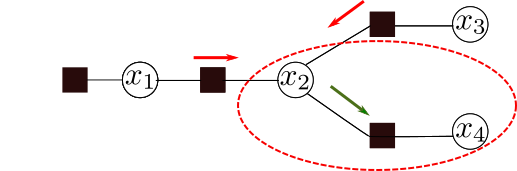

In [19]:
Image(filename='files/BN1-2.png')

In [20]:
# Computation of the joint pdf. Store in a table using the same tree-factorization than the used for CPDs!

msg_IN=factor_4['input_msgs'][0]['table'].reshape(-1,)
        
marg24=np.zeros(CPD_4.shape)
        
for position,cpd_value in enumerate(CPD_4):        
    
    #Store order x_2-->x4
    
    indexes=mp.CPD_position_to_variable_index(position,[v_card[1],v_card[3]],v_card[1]*v_card[3])
            
    marg24[position]+=cpd_value*np.exp(msg_IN[indexes[0]])  #Msgs defined in the logaritmic domain for numerical stability 
    
#We have to normalize!

marg24/=np.sum(marg24)
    
    
print("The joint marginal of nodes x_2 and x_4 is=")
print(marg24)



The joint marginal of nodes x_2 and x_4 is=
[ 0.025  0.4    0.025  0.05   0.1    0.1    0.25   0.05 ]
